# Messing with decision trees

Reference: https://developers.google.com/machine-learning/decision-forests/growing

Kaggle data source: https://www.kaggle.com/competitions/titanic/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

In [2]:
DATA = "data/titanic/"

In [3]:
train_raw = pd.read_csv(f'{DATA}train.csv')
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
males = train_raw.Sex == "male"
males = train_raw[males]
females = train_raw.Sex != "male"
females = train_raw[females]
np.average(males.Survived)

0.18890814558058924

In [5]:
np.unique(train_raw.Pclass)

array([1, 2, 3])

In [6]:
np.average(females.Survived)

0.7420382165605095

Alright, let's make a decision tree. Let's take the sex as the first feature we will look into. Breaking up the data in this scenario
is pretty trivial since sex can only take two values in this dataset. Let's look into the basic principles of the approach behind decision trees.

The idea behind decision trees is that we want to create a hierarchy of features within a dataset, that allow us to describe, and better predict,
an outcome given some set of features about a datapoint. Let's take the example of the Titanic dataset. I want to, given the data provided above, predict
whether a person will survive or die. Using just information about sex, by using a naive approach, I'm going to make a simple model:

```
if male => will die
else => will live
```

In this scenario, i'm just rounding the probability that a lady would die vs. a male. This model is crude, but, in the case of males, will be correct about 3/4 of the time. To make it more sophisticated, I can start nesting conditions. This nesting allows us to better capture the complexity of the data within our model. Nesting, in this case, could mean something like "is male and age is greater than 30". Conditions for now are always true or false, with the nesting resulting in a binary tree. The leafs of our tree are the probability of our dependent variable being the positive case given the precedeing conditions (i.e. probability that they will live).

An important part of decision trees is determining the order and structure of the hierarchy, since all we start out with are a list of features that we're interested in. A good measurement fo how good a feature is for predicting the dependent variable is by measuring the information gain that feature provides. How do we measure information gain? What does that even mean? Let's just start with the intuition that an increase in information results in an increase in heterogeneity. Information allows us to separate data. More information is equivalent to saying less entropy. The big idea is that entropy makes data hard to distinguish, information allows us to distinguish it. Like putting on a new pair of glasses.

### Measuring entropy

$$\begin{eqnarray}
R(X) & = & \frac{\lvert \{ x | x \in X \ \textrm{and} \ x = \mathrm{pos}  \} \rvert}{\lvert X \rvert} \\[12pt]
H(X) & = & - p \log p - (1 - p) \log (1-p) \ \textrm{with} \ p = R(X)\\[12pt]
\end{eqnarray}$$

$R(X)$ is the proportion of the data in X that takes on the positive condition in the dependent variable.
$H(X)$ is the Shannon Entropy.

In [7]:
# Let's define the positive condition as being alive :)
# Let's find the proportion of males that ended up alive, and let's do the same for females

r_male = np.average(males.Survived)
r_female = np.average(females.Survived)

# Let's then calculate the entropy from these proportions

def entropy(p):
    if p == 1 or p == 0 or np.isnan(p):
        return 0
    return -1 * p * np.log(p) - (1 - p) * np.log(1 - p)

h_male = entropy(r_male)
h_female = entropy(r_female)

In [8]:
# Let's also calculate the baseline entropy of the data

r_base = np.average(train_raw.Survived)
h_base = entropy(r_base)

In [9]:
h_base, h_female, h_male

(0.6659119735267652, 0.5709141922481396, 0.4846358858279689)

## Measuring information gain

Just take the base entropy, and subtract the weighted average of the entropies from the two splits.

$$\begin{eqnarray}
IG(D,T,F) & = & H(D) - \frac {\lvert T\rvert} {\lvert D \rvert } H(T) - \frac {\lvert F \rvert} {\lvert D \rvert } H(F)
\end{eqnarray}$$

IG -> Information Gained

Where $D$ represents the base set of the dependent variable, not filtered based on a feature's split (e.g. male vs. female for the sex feature)

In [10]:
ig = h_base - (males.size/train_raw.size) * h_male - (females.size/train_raw.size) * h_female
ig

0.15087048925218174

### Dang!

Now we have a way to evaluate how good a split of the data is based on a feature! **Big IG means more good.**

## What about finding the information gain from a continuous feature?

Let's analyze this using the fare column in the titanic data. We can split the continuous values by specifying a threshold value $t$. Splitting the data into two chunks:

$$\begin{eqnarray}
A = x \leq t \\[12pt]
B = x \gt t
\end{eqnarray}$$

From this, we can apply the same methods as before for calculating the information gain.

In [11]:
np.average(train_raw.Fare)

32.204207968574636

In [12]:
# Let's try out the average for our starting value of t
t = 32

fare_bt = train_raw[train_raw.Fare <= t]
fare_at = train_raw[train_raw.Fare > t]

r_fare_bt = np.average(fare_bt.Survived) # below t ;)
r_fare_at = np.average(fare_at.Survived) # above t ;)

h_fare_bt = entropy(r_fare_bt)
h_fare_at = entropy(r_fare_at)

ig_fare = h_base - (fare_bt.size/train_raw.size) * h_fare_bt - (fare_at.size/train_raw.size) * h_fare_at

ig_fare

0.029209702428192402

### Optimizing the choice of threshold

In [13]:
# let's first refactor our information gained calculations

def get_ig(t_arr, D, x, y):
    t = t_arr[0]
    x_bt = D[D[x] <= t]
    x_at = D[D[x] > t]
    r_x_bt = np.average(x_bt[y]) if x_bt.size > 0 else 0
    r_x_at = np.average(x_at[y]) if x_at.size > 0 else 0
    h_x_bt = entropy(r_x_bt)
    h_x_at = entropy(r_x_at)
    h_base = entropy(np.average(D[y]))
    return h_base - (x_bt.size/D.size) * h_x_bt - (x_at.size/D.size) * h_x_at

In [14]:
get_ig([270], train_raw, "Fare", "Survived")

0.0032331553602756857

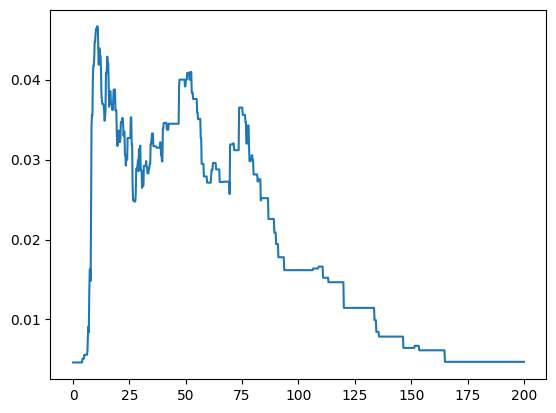

In [15]:
# let's graph the information gained for our choice of thresholds
min_fare = np.min(train_raw.Fare)
max_fare = np.max(train_raw.Fare)

possible_ts = np.linspace(min_fare, 200, 1000)
igs = [get_ig([t], train_raw, "Fare", "Survived") for t in possible_ts]

plt.plot(possible_ts, igs)

In [16]:
# Finding the exact maximum is not that important, since it's only going to be used to compare to other features
# this function is also incredibly jagged, meaning we're not going to benefit from any analytical speedups
# (we're very likely going to get trapped in some local minima/maxima)

# Let's just take a bunch of samples and get the max

possible_ts = np.linspace(min_fare, max_fare, 50)
igs = [get_ig([t], train_raw, "Fare", "Survived") for t in possible_ts]

np.max(igs)

0.046306237756263524

In [17]:
# Okay, let's try out age

possible_ts = np.linspace(np.min(train_raw.Age), np.max(train_raw.Age), 50)
igs = [get_ig([t], train_raw, "Age", "Survived") for t in possible_ts]
np.max(igs)

0.13476791463934662

In [31]:
# Interesting... age can generate a lot more information about survival than the ticket price
# Almost the same as gender in fact! Seems like the passengers on board the titanic were prioritizing
# aspects around gender and age in choosing who they should try to save.

# Let's look at the class the passengers were traveling in. Also, let's abstract the procedure we've been doing to get
# the max information gained

def max_ig_cont(D, x, y):
    distinct = np.unique(D[x]).size
    samples = 60
    possible_ts = np.linspace(np.min(D[x]), np.max(D[x]), samples)
    igs = [get_ig([t], D, x, y) for t in possible_ts]
    max_i = np.argmax(igs)
    return (possible_ts[max_i], igs[max_i])

In [33]:
# Testing it out
max_ig_cont(train_raw, "Age", "Survived")

(5.815254237288135, 0.13423724056807929)

In [35]:
max_ig_cont(train_raw, "Pclass", "Survived")

(2.016949152542373, 0.05253613916173083)

In [36]:
max_ig_cont(train_raw, "SibSp", "Survived")

(3.1186440677966103, 0.007151771240222402)

## Building the Decision Tree

The building of the decision tree follows this algorithm

```python
def train_decision_tree(training_examples):
  root = create_root() # Create a decision tree with a single empty root.
  grow_tree(root, training_examples) # Grow the root node.
  return root

def grow_tree(node, examples):
  condition = find_best_condition(examples) # Find the best condition.

  if condition is None:
    # No satisfying conditions were found, therefore the grow of the branch stops.
    set_leaf_prediction(node, examples)
    return

  # Create two childrens for the node.
  positive_child, negative_child = split_node(node, condition)

  # List the training examples used by each children.
  negative_examples = [example for example in examples if not condition(example)]
  positive_examples = [example for example in examples if condition(example)]

  # Continue the growth of the children.
  grow_tree(negative_child, negative_examples)
  grow_tree(positive_child, positive_examples)
```

In [ ]:
def train_decision_tree(D):
    